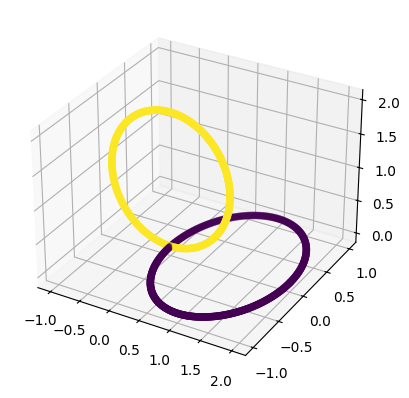

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
# Create a toy dataset of 2 interlocking rings in 3D and with 1000 points and labels for each point
# Create a toy dataset of interlocking rings perpendicular to each other in 3D
num_points = 500
theta = torch.linspace(0, 2 * torch.pi, num_points)

# First ring in the XY plane, centered at (1, 0, 0)
x1 = 1 + torch.cos(theta)
y1 = torch.sin(theta)
z1 = torch.zeros(num_points)

# Second ring in the XZ plane, centered at (0, 0, 1)
x2 = torch.cos(theta)
y2 = torch.zeros(num_points)
z2 = 1 + torch.sin(theta)

# Combine the rings
X1 = torch.stack([x1, y1, z1], dim=1)
X2 = torch.stack([x2, y2, z2], dim=1)
X = torch.cat([X1, X2], dim=0)

# Labels for the rings
Y1 = torch.zeros(num_points, dtype=torch.int32)
Y2 = torch.ones(num_points, dtype=torch.int32)
Y = torch.cat([Y1, Y2], dim=0)
# Plot the dataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap='viridis')
plt.show()


In [2]:
# Create a dataloader for the dataset
dataset = torch.utils.data.TensorDataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
# Split the dataset into a training and test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
!pip install wandb

   ---------------------------------------- 0.0/20.3 MB ? eta -:--:--
   ----------------- ---------------------- 8.9/20.3 MB 46.3 MB/s eta 0:00:01
   ------------------------------------ --- 18.6/20.3 MB 45.2 MB/s eta 0:00:01
   ---------------------------------------- 20.3/20.3 MB 36.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import torch
from model.fully_connected_network import FullyConnectedNetwork
from core.energy import HopfieldEnergy
from core.updater import FixedPointUpdater
from training.runner import Runner
from training.cost import SquaredError
from training.equilibrium_propagation import EquilibriumProp
from util.config import Config

config = Config()
network = FullyConnectedNetwork(config)
energy_fn = HopfieldEnergy(config)
cost_fn = SquaredError(config)
updater = FixedPointUpdater(network, energy_fn, cost_fn, config)
differentiator = EquilibriumProp(energy_fn, cost_fn, updater, config)
W, B = network.weights, network.bias # Need to verify if pointer or new creation. It should be pointer already but sanity check. 
optimizer = torch.optim.SGD([W, B], lr=0.01)



runner = Runner(config, network, train_loader, differentiator, updater, optimizer, inference_dataloader=None)
runner.run_training()

FileNotFoundError: [Errno 2] No such file or directory: 'default_config.json'